# Implementation Quantum Walk

### Introduction and Problem Statement
- A quantum walk is the quantum analog of a classical random walk. Unlike classical random walks where a particle moves randomly to neighboring nodes, a quantum walk allows a particle to exist in a superposition of states, enabling it to explore multiple paths simultaneously. This characteristic makes quantum walks powerful tools for designing quantum algorithms with potential applications in search algorithms, quantum simulations, and more.

- In this notebook, we aim to simulate a quantum walk on a line with 16 nodes using the Classiq Python SDK. We will define the quantum walk operators, simulate the walk, and visualize the results.
  
  
   ![My Image](quantum_walk.png)
  
- The quantum walk on a line involves creating a quantum state that represents the positions of the walker. The walker's position is updated based on specific rules encoded in quantum operators. In our case, we will use Hadamard gates to create superposition and additional quantum gates to define the walk's dynamics.

## Explanation of the different steps of the implementation of the algorithm

- **<span style="color:blue">Prepare_minus(x: QBit)</span>**
  - This function applies the X and H gates to a qubit `x`, preparing it in the |-> state.
  - **X(x)**: Applies the Pauli-X gate, which flips the qubit state.
  - **H(x)**: Applies the Hadamard gate, which creates a superposition.


- **<span style="color:blue">diffuser_oracle(aux: Output[QNum], x: QNum)</span>**
  - This function defines a diffuser oracle which modifies the auxiliary qubit `aux` based on the state of the quantum number `x`.
  - **aux ^= (x != 0)**: Applies a controlled NOT operation to the auxiliary qubit if `x` is not zero.


- **<span style="color:blue">zero_diffuser(x: QNum)</span>**
  - This function prepares an auxiliary qubit in the |-> state and applies the diffuser oracle.
  - **aux = QNum('aux')**: Allocates an auxiliary qubit.
  - **within_apply(...)**: Uses the auxiliary qubit within a quantum operation.


- **<span style="color:blue">W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum)</span>**
  - This function defines the probability vector for the walker at each node and applies the zero diffuser to update the walker's state.
  - **prob**: Probability vector initialized with zeros.
  - **control(...)**: Controls the operation based on the walker's position.


- **<span style="color:blue">W_operator(vertices: QNum, adjacent_vertices: QNum)</span>**
  - This function applies the W_iteration for all nodes, effectively implementing the walk operator.
  - **for i in range(2 ** size)**: Iterates over all nodes.


- **<span style="color:blue">edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum)</span>**
  - This function defines an edge oracle to determine if an edge exists between vertices.
  - **res |= (((vertices + adjacent_vertices) % 2) == 1)**: Applies a condition to the result qubit.


- **<span style="color:blue">bitwise_swap(x: QArray[QBit], y: QArray[QBit])</span>**
  - This function swaps the states of two quantum arrays.
  - **repeat(...)**: Repeats the SWAP operation for all elements.


- **<span style="color:blue">S_operator(vertices: QNum, adjacent_vertices: QNum)</span>**
  - This function applies the edge oracle and swaps the states of vertices if the condition is met.
  - **res = QNum('res')**: Allocates a result qubit.
  - **control(...)**: Controls the SWAP operation based on the edge oracle's result.


- **<span style="color:blue">main(vertices: Output[QNum], adjacent_vertices: Output[QNum])</span>**
  - This is the main function that initializes the qubits, applies the Hadamard transform, and executes the W and S operators.
  - **allocate(size, vertices)**: Allocates the vertices qubits.
  - **hadamard_transform(vertices)**: Applies Hadamard gates to create superposition.
  - **W_operator(vertices, adjacent_vertices)**: Applies the walk operator.
  - **S_operator(vertices, adjacent_vertices)**: Applies the swap operator.


In [45]:
from classiq import *
size = 4  # 16 nodes require 4 qubits


In [46]:
@qfunc
def prepare_minus(x: QBit):
    """
    Applies the X and H gates to prepare the qubit in the |-> state.
    """
    X(x)
    H(x)

In [47]:
@qfunc
def diffuser_oracle(aux: Output[QNum], x: QNum):
    """
    Defines a diffuser oracle which modifies the auxiliary qubit based on the state of x.
    """
    aux ^= (x != 0)

In [48]:
@qfunc
def zero_diffuser(x: QNum):
    """
    Prepares an auxiliary qubit in the |-> state and applies the diffuser oracle.
    """
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuser_oracle)

In [49]:
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    """
    Defines the probability vector for the walker at each node and applies the zero diffuser.
    """
    prob = [0] * (2 ** size)
    if i == 0:
        prob[i + 1] = 1.0
    elif i == (2 ** size) - 1:
        prob[i - 1] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'Node={i}, prob vec ={prob}')

    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuser(adjacent_vertices)))

In [51]:

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    """
    Applies the W_iteration for all nodes, implementing the walk operator.
    """
    for i in range(2 ** size):
        W_iteration(i, vertices, adjacent_vertices)

In [53]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Defines an edge oracle to determine if an edge exists between vertices.
    """
    res |= (((vertices + adjacent_vertices) % 2) == 1)

In [55]:
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    """
    Swaps the states of two quantum arrays.
    """
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

In [57]:
@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    """
    Applies the edge oracle and swaps the states of vertices if the condition is met.
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [58]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    """
    Initializes the qubits, applies the Hadamard transform, and executes the W and S operators.
    """
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)
    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

In [59]:

# Create and visualize the quantum circuit
qmod_line = create_model(main)
qprog_line = synthesize(qmod_line)
show(qprog_line)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

In [60]:
# Simulate the quantum walk on a line with 16 nodes
from classiq import execute

# Execute the quantum program and handle the results
try:
    job_line = execute(qprog_line)
    result = job_line.result()
    results_line = result[0].value.parsed_counts
    print("Results for Line with 16 Nodes:")
    print(results_line)
except Exception as e:
    print(f"Error executing the quantum program: {e}")


Results for Line with 16 Nodes:
[{'vertices': 10.0, 'adjacent_vertices': 0.0}: 151, {'vertices': 6.0, 'adjacent_vertices': 0.0}: 150, {'vertices': 14.0, 'adjacent_vertices': 0.0}: 140, {'vertices': 0.0, 'adjacent_vertices': 13.0}: 137, {'vertices': 0.0, 'adjacent_vertices': 0.0}: 135, {'vertices': 0.0, 'adjacent_vertices': 5.0}: 130, {'vertices': 0.0, 'adjacent_vertices': 9.0}: 130, {'vertices': 0.0, 'adjacent_vertices': 7.0}: 128, {'vertices': 0.0, 'adjacent_vertices': 3.0}: 126, {'vertices': 8.0, 'adjacent_vertices': 0.0}: 125, {'vertices': 0.0, 'adjacent_vertices': 11.0}: 123, {'vertices': 0.0, 'adjacent_vertices': 15.0}: 123, {'vertices': 2.0, 'adjacent_vertices': 0.0}: 121, {'vertices': 4.0, 'adjacent_vertices': 0.0}: 114, {'vertices': 0.0, 'adjacent_vertices': 1.0}: 113, {'vertices': 12.0, 'adjacent_vertices': 0.0}: 102]


## Circuit Visualization 

![My Image](picturea.png)

## Probability 
![My Image](pictureb.png)

## Count
![My Image](pictureb.png)

## Visualization of the quantum walk

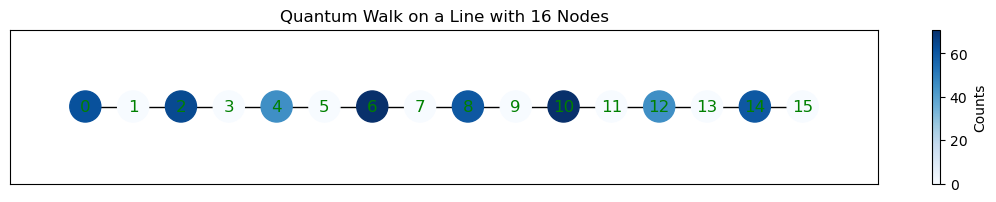

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a path graph for visualization
G = nx.path_graph(16)  # 16 nodes in a line
pos = {i: (i, 0) for i in range(16)}  # Position nodes in a line

# Data from the histogram
states = ['10010000', '10110000', '11010000', '11110000', '00001010', '00001100', '00001110', '00000000', 
          '01010000', '00000110', '00001000', '00110000', '00000100', '00010000', '00000010', '01110000']
counts = [69, 61, 72, 58, 71, 45, 60, 62, 73, 71, 60, 70, 45, 57, 64, 62]

# Extract vertex counts
vertex_counts = {int(state, 2): count for state, count in zip(states, counts)}

# Prepare colors based on the counts
colors = [vertex_counts.get(node, 0) for node in G.nodes()]

# Plot the graph with color differentiation
fig, ax = plt.subplots(figsize=(14, 2))
nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=plt.cm.Blues, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, font_color='green', ax=ax)

plt.title('Quantum Walk on a Line with 16 Nodes')
plt.colorbar(nodes, label='Counts')
plt.show()


## Interpretation of the results.
- The histogram plot shows the distribution of the measured states after the execution of the quantum walk. Each bar in the histogram represents the probability of occurrences for a particular state.
- In a quantum walk, the probability of the walker being at a certain position is distributed according to the unitary evolution of the walk operator. The results show that certain positions (vertices) have higher probabilities, which are reflected in the counts. These positions represent where the quantum walker is most likely to be found after the evolution.
- The quantum walker seems to have higher probabilities of being found at certain nodes (like 0, 2, 4, 6, 8, 10, 12, and 14), suggesting some structure or pattern in the walk.
- The color intensity provides a clear visual indication of where the quantum walker spends most of its time, with the darkest nodes being the most frequently visited.
- This visualization provides an intuitive understanding of the quantum walk distribution across the nodes. Nodes with higher counts (darker colors) are more frequently visited by the quantum walker, indicating potential regions of higher probability in the quantum walk. This type of visualization is helpful for analyzing the behavior and properties of quantum walks on different graph structures.

- In conclusion the quantum walk simulation results show a distribution of probabilities across different states (vertices). The high counts for certain states indicate the likelihood of finding the walker at those vertices. The histogram provides a visual representation of these probabilities, while the table offers a detailed breakdown of counts and positions.